In [ ]:
import pandas as pd
import numpy as np
import os
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import pickle
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import umap

Load dataset

In [ ]:
path = "" # Path to dataset

# Load sales data
train_df = pd.read_csv(Path(path + '/train.csv'), parse_dates=['release_date'])
test_df = pd.read_csv(Path(path + '/test.csv'), parse_dates=['release_date'])

In [13]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


class ZeroShotDataset():
    def __init__(self, data_df, img_root, gtrends, cat_dict, col_dict, fab_dict, trend_len):
        self.data_df = data_df
        self.gtrends = gtrends
        self.cat_dict = cat_dict
        self.col_dict = col_dict
        self.fab_dict = fab_dict
        self.trend_len = trend_len
        self.img_root = img_root

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        return self.data_df.iloc[idx, :]

    def preprocess_data(self):
        data = self.data_df

        # Get the Gtrends time series associated with each product
        # Read the images (extracted image features) as well
        gtrends, image_features = [], []
        img_transforms = Compose([Resize((256, 256)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        for (idx, row) in tqdm(data.iterrows(), total=len(data), ascii=True):
            cat, col, fab, fiq_attr, start_date, img_path = row['category'], row['color'], row['fabric'], row['extra'], \
                row['release_date'], row['image_path']

            # Get the gtrend signal up to the previous year (52 weeks) of the release date
            gtrend_start = start_date - pd.DateOffset(weeks=52) # Set the initial date to 52 weeks before the release date
            cat_gtrend = self.gtrends.loc[gtrend_start:start_date][cat][-52:].values[:self.trend_len] # Get the last 52 weeks of the gtrend signal and "store - it" to each item
            col_gtrend = self.gtrends.loc[gtrend_start:start_date][col][-52:].values[:self.trend_len]
            fab_gtrend = self.gtrends.loc[gtrend_start:start_date][fab][-52:].values[:self.trend_len]

            cat_gtrend = MinMaxScaler().fit_transform(cat_gtrend.reshape(-1,1)).flatten() # Normalize the gtrend signals - all categories on the same scale
            col_gtrend = MinMaxScaler().fit_transform(col_gtrend.reshape(-1,1)).flatten()
            fab_gtrend = MinMaxScaler().fit_transform(fab_gtrend.reshape(-1,1)).flatten()
            multitrends =  np.vstack([cat_gtrend, col_gtrend, fab_gtrend])


            # Read images
            img = Image.open(os.path.join(self.img_root, img_path)).convert('RGB')

            # Append them to the lists
            gtrends.append(multitrends)
            image_features.append(img_transforms(img))

        # Convert to numpy arrays
        gtrends = np.array(gtrends)

        # Remove non-numerical information
        data.drop(['external_code', 'season', 'release_date', 'image_path'], axis=1, inplace=True)

        # Create tensors for each part of the input/output
        item_sales, temporal_features = torch.FloatTensor(data.iloc[:, :12].values), torch.FloatTensor(
            data.iloc[:, 13:17].values)
        categories, colors, fabrics = [self.cat_dict[val] for val in data.iloc[:].category.values], \
                                       [self.col_dict[val] for val in data.iloc[:].color.values], \
                                       [self.fab_dict[val] for val in data.iloc[:].fabric.values]

        
        categories, colors, fabrics = torch.LongTensor(categories), torch.LongTensor(colors), torch.LongTensor(fabrics)
        gtrends = torch.FloatTensor(gtrends)
        images = torch.stack(image_features)

        return TensorDataset(item_sales, categories, colors, fabrics, temporal_features, gtrends, images)

    def get_loader(self, batch_size, train=True):
        print('Starting dataset creation process...')
        data_with_gtrends = self.preprocess_data()
        data_loader = None
        if train:
            data_loader = DataLoader(data_with_gtrends, batch_size=batch_size, shuffle=True, num_workers=4)
        else:
            data_loader = DataLoader(data_with_gtrends, batch_size=1, shuffle=False, num_workers=4)
        print('Done.')

        return data_loader

In [14]:
from pathlib import Path

 # Load category and color encodings
cat_dict = torch.load(Path(path + '/category_labels.pt'))
col_dict = torch.load(Path(path + '/color_labels.pt'))
fab_dict = torch.load(Path(path + '/fabric_labels.pt'))

gtrends = pd.read_csv(Path(path + '/gtrends.csv'), index_col=[0], parse_dates=True)

/tmp/ipykernel_9887/1618174958.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cat_dict = torch.load(Path(path + '/category_labels.pt'))
/tmp/ipykernel_9887/1618174958.p

In [15]:
train_loader = ZeroShotDataset(train_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                   fab_dict, 52).get_loader(batch_size=32, train=True)
test_loader = ZeroShotDataset(test_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                  fab_dict, 52).get_loader(batch_size=1, train=False)

Starting dataset creation process...


100%|##########| 5080/5080 [01:48<00:00, 46.72it/s] 


Done.
Starting dataset creation process...


100%|##########| 497/497 [00:10<00:00, 45.32it/s]


Done.


In [16]:
# Extract the data from the DataLoader for EDA
item_sales_list, categories_list, colors_list, fabrics_list, temporal_features_list, gtrends_list, images_list = [], [], [], [], [], [], []

for item_sales_i, categories_i, colors_i, fabrics_i, temporal_features_i, gtrends_i, images_i in train_loader:
    item_sales_list.append(item_sales_i.numpy())
    categories_list.append(categories_i.numpy())
    colors_list.append(colors_i.numpy())
    fabrics_list.append(fabrics_i.numpy())
    temporal_features_list.append(temporal_features_i.numpy())
    gtrends_list.append(gtrends_i.numpy())
    images_list.append(images_i.numpy())

# Convert lists to arrays for analysis
item_sales = np.concatenate(item_sales_list)
categories = np.concatenate(categories_list)
colors = np.concatenate(colors_list)
fabrics = np.concatenate(fabrics_list)
temporal_features = np.concatenate(temporal_features_list)
gtrends = np.concatenate(gtrends_list)
images = np.concatenate(images_list)

In [17]:
# Extract the data from the DataLoader for EDA
item_sales_list_test, categories_list_test, colors_list_test, fabrics_list_test, temporal_features_list_test, gtrends_list_test, images_list_test = [], [], [], [], [], [], []

for item_sales_i, categories_i, colors_i, fabrics_i, temporal_features_i, gtrends_i, images_i in test_loader:
    item_sales_list_test.append(item_sales_i.numpy())
    categories_list_test.append(categories_i.numpy())
    colors_list_test.append(colors_i.numpy())
    fabrics_list_test.append(fabrics_i.numpy())
    temporal_features_list_test.append(temporal_features_i.numpy())
    gtrends_list_test.append(gtrends_i.numpy())
    images_list_test.append(images_i.numpy())

item_sales_test = np.concatenate(item_sales_list_test)
categories_test = np.concatenate(categories_list_test)
colors_test = np.concatenate(colors_list_test)
fabrics_test = np.concatenate(fabrics_list_test)
temporal_features_test = np.concatenate(temporal_features_list_test)
gtrends_test = np.concatenate(gtrends_list_test)
images_test = np.concatenate(images_list_test)

In [18]:
images.shape

(5080, 3, 256, 256)

### Exploratory Data Analysis

In [43]:
# Calculate total sales per item across the 12 numerical values
total_sales = item_sales.sum(axis=1)
first_sales = item_sales[:, 0]
total_sales_test = item_sales_test.sum(axis=1)
first_sales_test = item_sales_test[:, 0]

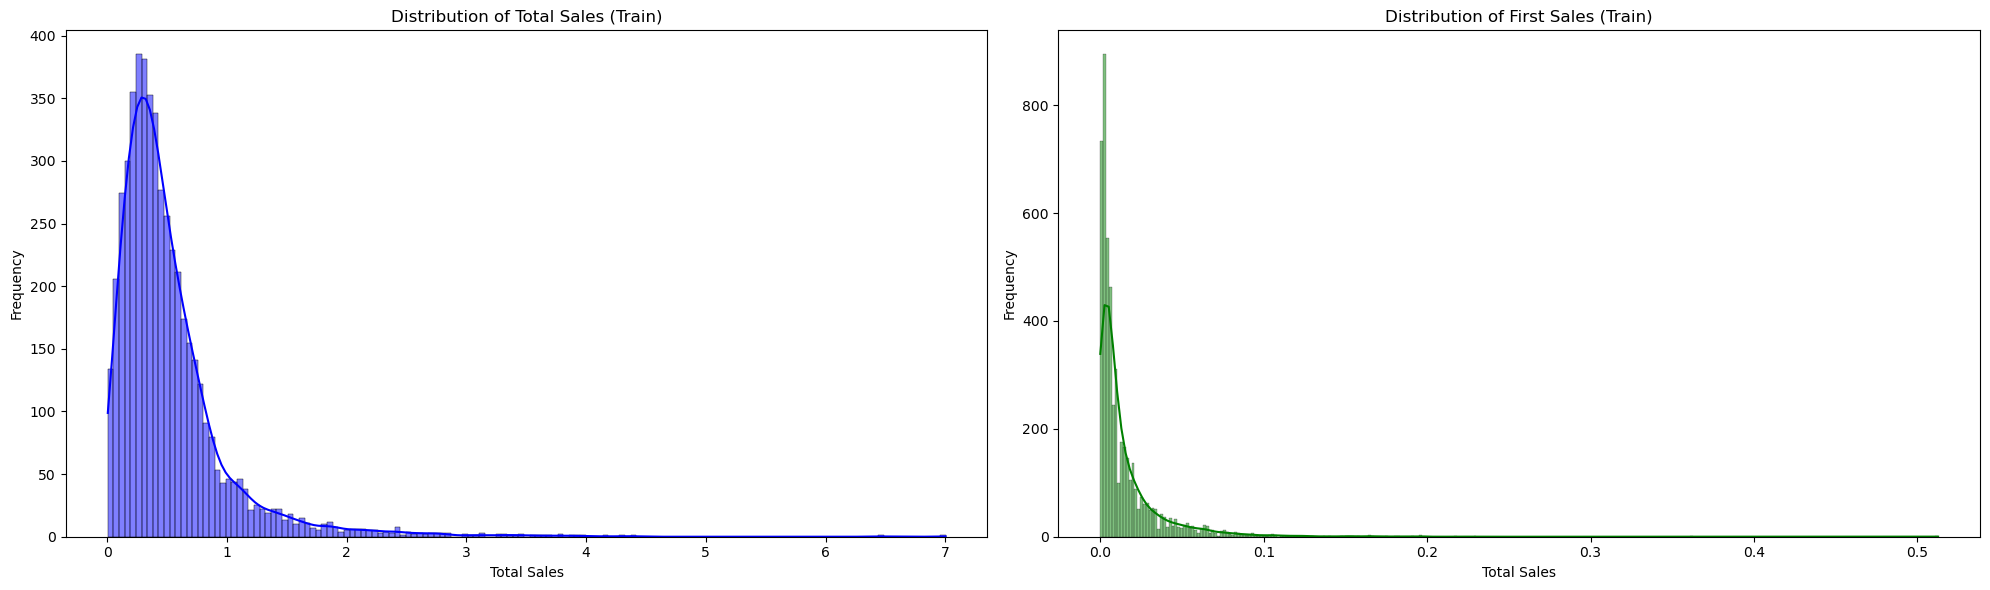

count    5080.000000
mean        0.014884
std         0.023272
min         0.000000
25%         0.002817
50%         0.006573
75%         0.017840
max         0.512676
dtype: float64

In [24]:
# total_sales_test = item_sales_test.sum(axis=1)

# Plot the distribution of total sales
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the distribution of total sales for training data
sns.histplot(total_sales, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Distribution of Total Sales (Train)")
axes[0].set_xlabel("Total Sales")
axes[0].set_ylabel("Frequency")

# Plot the distribution of total sales for test data
sns.histplot(first_sales, kde=True, color='green', ax=axes[1])
axes[1].set_title("Distribution of First Sales (Train)")
axes[1].set_xlabel("Total Sales")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

pd.Series(total_sales).describe()
pd.Series(first_sales).describe()

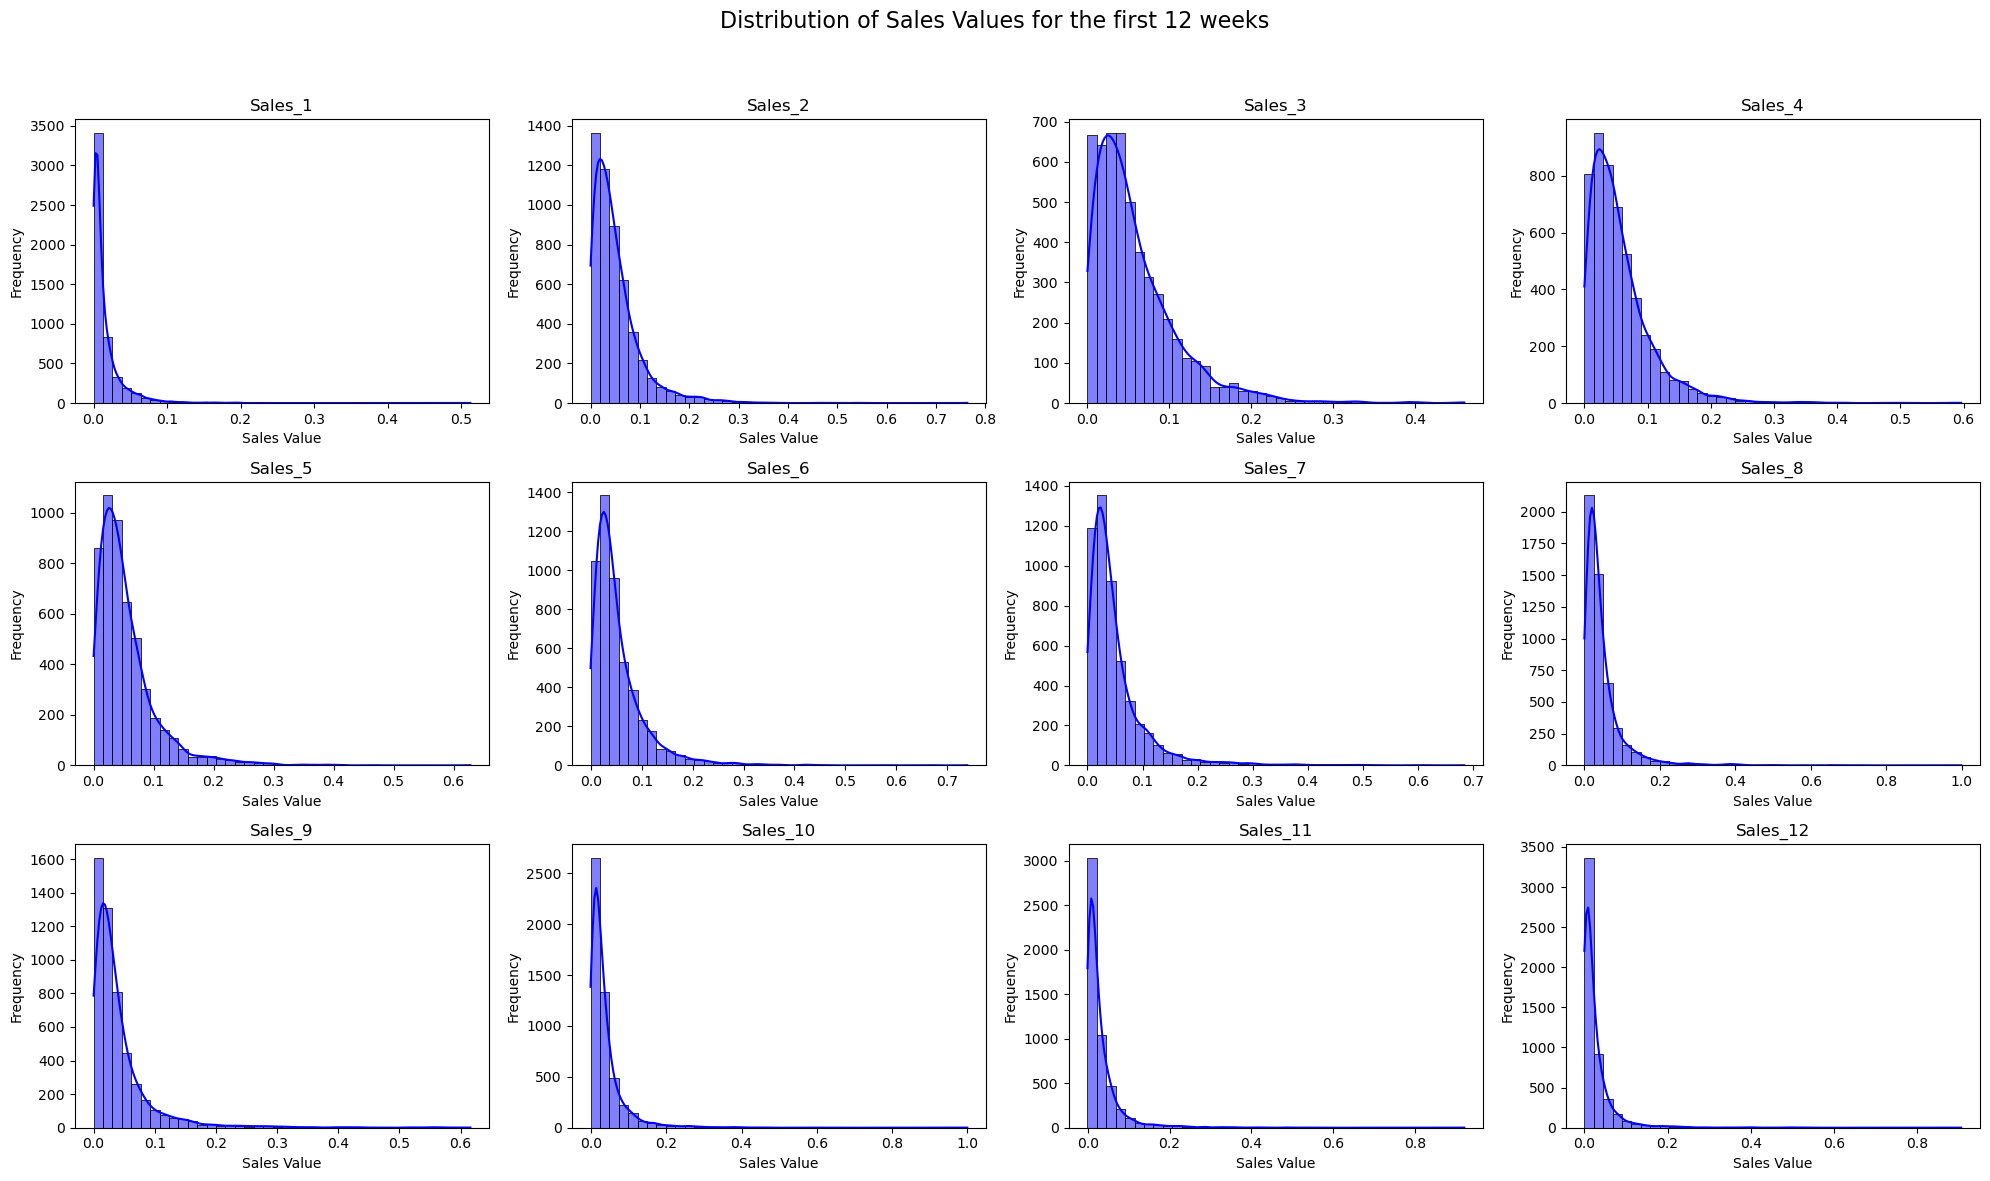

In [11]:
# Set up a grid of 3x4 subplots
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
fig.suptitle("Distribution of Sales Values for the first 12 weeks", fontsize=16)

# Plot each sales distribution in a separate subplot
for i in range(12):
    row = i // 4
    col = i % 4
    sns.histplot(item_sales[:, i], kde=True, color='blue', ax=axes[row, col], bins=40)
    axes[row, col].set_title(f"Sales_{i + 1}")
    axes[row, col].set_xlabel("Sales Value")
    axes[row, col].set_ylabel("Frequency")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [25]:
# Convert Week, Month, and Year to proper integers
sales_trend_df = pd.DataFrame({
    "Week": (temporal_features[:, 1] * 52).astype(int),  # Week of the year
    "Month": (temporal_features[:, 2] * 12).astype(int),  # Month of the year
    "Year": (temporal_features[:, 3] * 10).astype(int),  # Year
    # "Total Sales": total_sales,
    "Total Sales": first_sales,
    "Category": categories
})

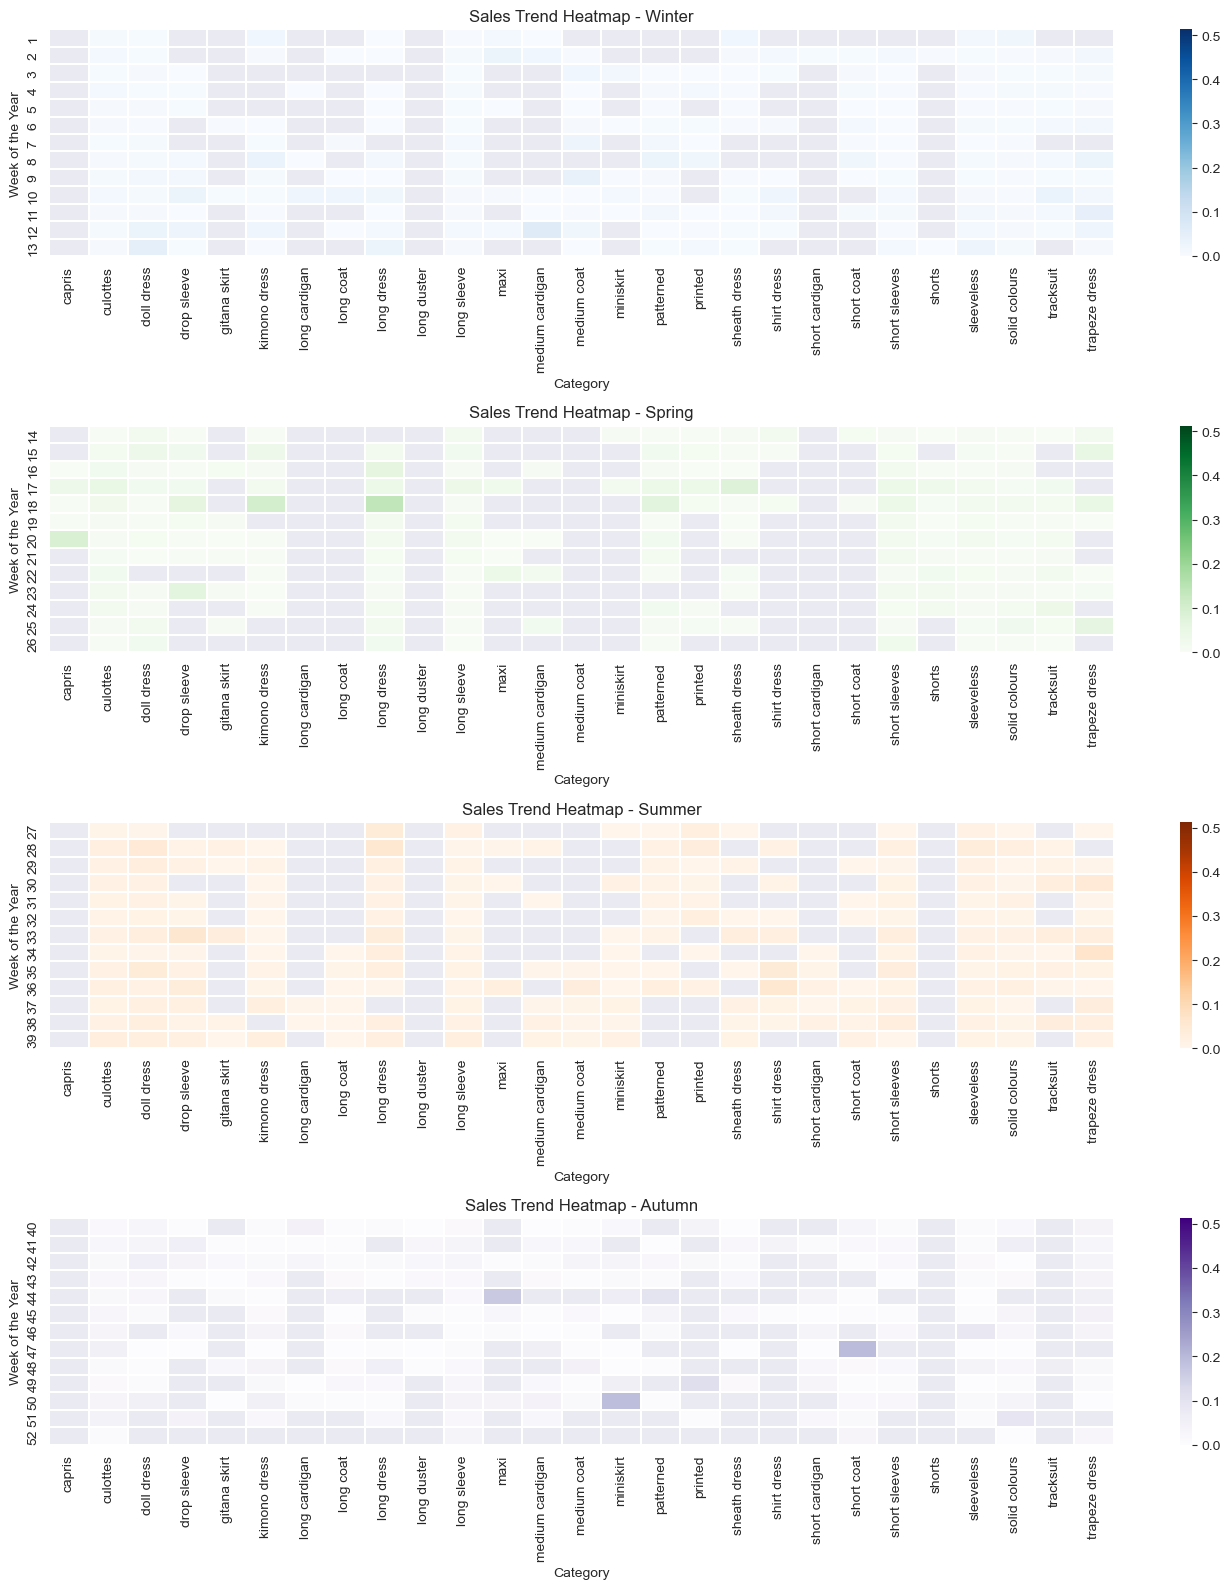

In [13]:
sns.set_style("dark")  # Options: "whitegrid", "darkgrid", "dark", "white", "ticks"

# Define a function to classify weeks into seasons
def classify_season(week):
    if week in range(1, 14):  # Weeks 1-13: Winter
        return "Winter"
    elif week in range(14, 27):  # Weeks 14-26: Spring
        return "Spring"
    elif week in range(27, 40):  # Weeks 27-39: Summer
        return "Summer"
    else:  # Weeks 40-52: Autumn
        return "Autumn"


reversed_cat_dict = {v: k for k, v in cat_dict.items()}

# Apply the classification to create a new Season column
sales_trend_df["Category"] = sales_trend_df["Category"].map(reversed_cat_dict)
all_categories = sorted(sales_trend_df["Category"].unique())

sales_trend_df["Season"] = sales_trend_df["Week"].apply(classify_season)

# Calculate the global min and max for the color scale
global_min = sales_trend_df["Total Sales"].min()
global_max = sales_trend_df["Total Sales"].max()

# Plot the heatmap for each season with different colormaps
plt.figure(figsize=(14, 16))
for i, season in enumerate(["Winter", "Spring", "Summer", "Autumn"]):
    season_data = sales_trend_df[sales_trend_df["Season"] == season]
    season_pivot = season_data.pivot_table(values="Total Sales", index="Week", columns="Category", aggfunc='mean').reindex(columns=all_categories)

    # Plot the heatmap for the current season with a consistent color scale
    plt.subplot(4, 1, i + 1)
    sns.heatmap(season_pivot, cmap="Blues" if season == "Winter" else 
                                      "Greens" if season == "Spring" else 
                                      "Oranges" if season == "Summer" else 
                                      "Purples",
                vmin=global_min, vmax=global_max,
                linewidths=0.1)
    
    plt.title(f"Sales Trend Heatmap - {season}")
    plt.xlabel("Category")
    plt.ylabel("Week of the Year")

plt.tight_layout()
plt.show()

### Extraction of temporal features

In [27]:
# Convert scaled temporal features back to integers
week_of_year = (temporal_features[:, 1] * 52).astype(int)  # Week of the year (1 to 52)
month_of_year = (temporal_features[:, 2] * 12).astype(int)  # Month of the year (1 to 12)
year = (temporal_features[:, 3] * 10).astype(int)  # Year (scaled up to a meaningful range)

# Additional derived features
is_weekend = (week_of_year % 7 >= 5).astype(int)  # Flag indicating if it's a weekend (Saturday or Sunday)
quarter = ((month_of_year - 1) // 3 + 1).astype(int)  # Calculate the quarter (1 to 4)
season = np.select(
    [month_of_year <= 2, (month_of_year >= 3) & (month_of_year <= 5),
     (month_of_year >= 6) & (month_of_year <= 8), month_of_year >= 9],
    [0, 1, 2, 3])  # Define seasons (Winter, Spring, Summer, Fall)

# Combine all features into a new feature matrix
temporal_features_engineered = np.column_stack([
    week_of_year, month_of_year, year, is_weekend, quarter, season
])

In [28]:
temporal_features_engineered.shape

(5080, 6)

In [29]:
# Convert scaled temporal features back to integers for test data
test_week_of_year = (temporal_features_test[:, 1] * 52).astype(int)  # Week of the year (1 to 52)
test_month_of_year = (temporal_features_test[:, 2] * 12).astype(int)  # Month of the year (1 to 12)
test_year = (temporal_features_test[:, 3] * 10).astype(int)  # Year (scaled up to a meaningful range)

# Additional derived features for test data
test_is_weekend = (test_week_of_year % 7 >= 5).astype(int)  # Flag indicating if it's a weekend (Saturday or Sunday)
test_quarter = ((test_month_of_year - 1) // 3 + 1).astype(int)  # Calculate the quarter (1 to 4)
test_season = np.select(
    [test_month_of_year <= 2, (test_month_of_year >= 3) & (test_month_of_year <= 5),
     (test_month_of_year >= 6) & (test_month_of_year <= 8), test_month_of_year >= 9],
    [0, 1, 2, 3])  # Define seasons (Winter, Spring, Summer, Fall)

# Combine all features into a new feature matrix for test data
test_temporal_features_engineered = np.column_stack([
    test_week_of_year, test_month_of_year, test_year, test_is_weekend, test_quarter, test_season
])

### Rolling features

In [30]:
gtrends.shape

(5080, 3, 52)

In [35]:
# Get the dimensions of gtrends
num_samples, num_trends, trend_len = gtrends.shape

# Initialize arrays for rolling features
rolling_avg_4w = np.zeros((num_samples, num_trends, trend_len))  # 4-week rolling average
rolling_avg_12w = np.zeros((num_samples, num_trends, trend_len))  # 12-week rolling average
rolling_sum_4w = np.zeros((num_samples, num_trends, trend_len))  # 4-week rolling sum
rolling_sum_12w = np.zeros((num_samples, num_trends, trend_len))  # 12-week rolling sum

# Calculate rolling features for each trend channel
for i in range(num_samples):
    for j in range(num_trends):
        # Use pandas Series to calculate rolling averages and sums for each trend
        gtrend_series = pd.Series(gtrends[i, j])

        # Calculate 4-week and 12-week rolling averages and sums
        rolling_avg_4w[i, j] = gtrend_series.rolling(window=4, min_periods=1).mean().values
        rolling_avg_12w[i, j] = gtrend_series.rolling(window=12, min_periods=1).mean().values
        rolling_sum_4w[i, j] = gtrend_series.rolling(window=4, min_periods=1).sum().values
        rolling_sum_12w[i, j] = gtrend_series.rolling(window=12, min_periods=1).sum().values

# Combine the original gtrends with the new rolling features
# gtrends_with_rolling = np.concatenate([
#     gtrends, rolling_avg_4w, rolling_avg_12w, rolling_sum_4w, rolling_sum_12w
# ], axis=1)
gtrends_with_rolling = np.concatenate([
    rolling_avg_4w, rolling_avg_12w, rolling_sum_4w, rolling_sum_12w
], axis=1)

In [36]:
gtrends_with_rolling.shape

(5080, 12, 52)

In [39]:
# Get the dimensions of gtrends
num_samples, num_trends, trend_len = gtrends.shape

# Initialize lists for the reduced rolling features
rolling_avg_4w_list = []
rolling_avg_12w_list = []
rolling_sum_4w_list = []
rolling_sum_12w_list = []

# Calculate rolling features for each trend channel
for i in range(num_samples):
    rolling_avg_4w_sample = []
    rolling_avg_12w_sample = []
    rolling_sum_4w_sample = []
    rolling_sum_12w_sample = []
    
    for j in range(num_trends):
        # Use pandas Series to calculate rolling averages and sums for each trend
        gtrend_series = pd.Series(gtrends[i, j])

        # Calculate rolling averages and sums and take the last value of each rolling window
        rolling_avg_4w_sample.append(gtrend_series.rolling(window=4, min_periods=1).mean().iloc[-1])
        rolling_avg_12w_sample.append(gtrend_series.rolling(window=12, min_periods=1).mean().iloc[-1])
        rolling_sum_4w_sample.append(gtrend_series.rolling(window=4, min_periods=1).sum().iloc[-1])
        rolling_sum_12w_sample.append(gtrend_series.rolling(window=12, min_periods=1).sum().iloc[-1])
    
    # Append the results for this sample
    rolling_avg_4w_list.append(rolling_avg_4w_sample)
    rolling_avg_12w_list.append(rolling_avg_12w_sample)
    rolling_sum_4w_list.append(rolling_sum_4w_sample)
    rolling_sum_12w_list.append(rolling_sum_12w_sample)

# Convert lists to arrays
rolling_avg_4w = np.array(rolling_avg_4w_list)
rolling_avg_12w = np.array(rolling_avg_12w_list)
rolling_sum_4w = np.array(rolling_sum_4w_list)
rolling_sum_12w = np.array(rolling_sum_12w_list)

# Combine only the reduced rolling features into a single array
gtrends_with_rolling_reduced = np.hstack([
    rolling_avg_4w, rolling_avg_12w, rolling_sum_4w, rolling_sum_12w
])

In [40]:
gtrends_with_rolling_reduced.shape

(5080, 12)

In [41]:
# Get the dimensions of gtrends_test
num_samples_test, num_trends_test, trend_len_test = gtrends_test.shape

# Initialize lists for the reduced rolling features
rolling_avg_4w_test_list = []
rolling_avg_12w_test_list = []
rolling_sum_4w_test_list = []
rolling_sum_12w_test_list = []

# Calculate rolling features for each trend channel
for i in range(num_samples_test):
    rolling_avg_4w_sample_test = []
    rolling_avg_12w_sample_test = []
    rolling_sum_4w_sample_test = []
    rolling_sum_12w_sample_test = []
    
    for j in range(num_trends_test):
        # Use pandas Series to calculate rolling averages and sums for each trend
        gtrend_test_series = pd.Series(gtrends_test[i, j])

        # Calculate rolling averages and sums and take the last value of each rolling window
        rolling_avg_4w_sample_test.append(gtrend_test_series.rolling(window=4, min_periods=1).mean().iloc[-1])
        rolling_avg_12w_sample_test.append(gtrend_test_series.rolling(window=12, min_periods=1).mean().iloc[-1])
        rolling_sum_4w_sample_test.append(gtrend_test_series.rolling(window=4, min_periods=1).sum().iloc[-1])
        rolling_sum_12w_sample_test.append(gtrend_test_series.rolling(window=12, min_periods=1).sum().iloc[-1])
    
    # Append the results for this sample
    rolling_avg_4w_test_list.append(rolling_avg_4w_sample_test)
    rolling_avg_12w_test_list.append(rolling_avg_12w_sample_test)
    rolling_sum_4w_test_list.append(rolling_sum_4w_sample_test)
    rolling_sum_12w_test_list.append(rolling_sum_12w_sample_test)

# Convert lists to arrays
rolling_avg_4w_test = np.array(rolling_avg_4w_test_list)
rolling_avg_12w_test = np.array(rolling_avg_12w_test_list)
rolling_sum_4w_test = np.array(rolling_sum_4w_test_list)
rolling_sum_12w_test = np.array(rolling_sum_12w_test_list)

# Combine only the reduced rolling features into a single array
gtrends_test_with_rolling_reduced = np.hstack([
    rolling_avg_4w_test, rolling_avg_12w_test,
    rolling_sum_4w_test, rolling_sum_12w_test
])

### CREATE Bag of Visual Words

In [46]:
def denormalize_image(image):
    image = np.transpose(image, (1, 2, 0))   
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = std * image + mean
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    
    return image

In [47]:
sift = cv2.SIFT_create()

def extact_sift_features(image_array):
    
    image = denormalize_image(image_array)

    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

descriptors_list = []
keypoints_list = []
for image in tqdm(images):
    keypoints, descriptors = extact_sift_features(image)
    
    if descriptors is not None:
        descriptors_list.append(descriptors)
        keypoints_list.append(keypoints)
    else:
        descriptors_list.append(np.zeros((1, 128)))
        keypoints_list.append([])

100%|██████████| 5080/5080 [00:54<00:00, 93.61it/s] 


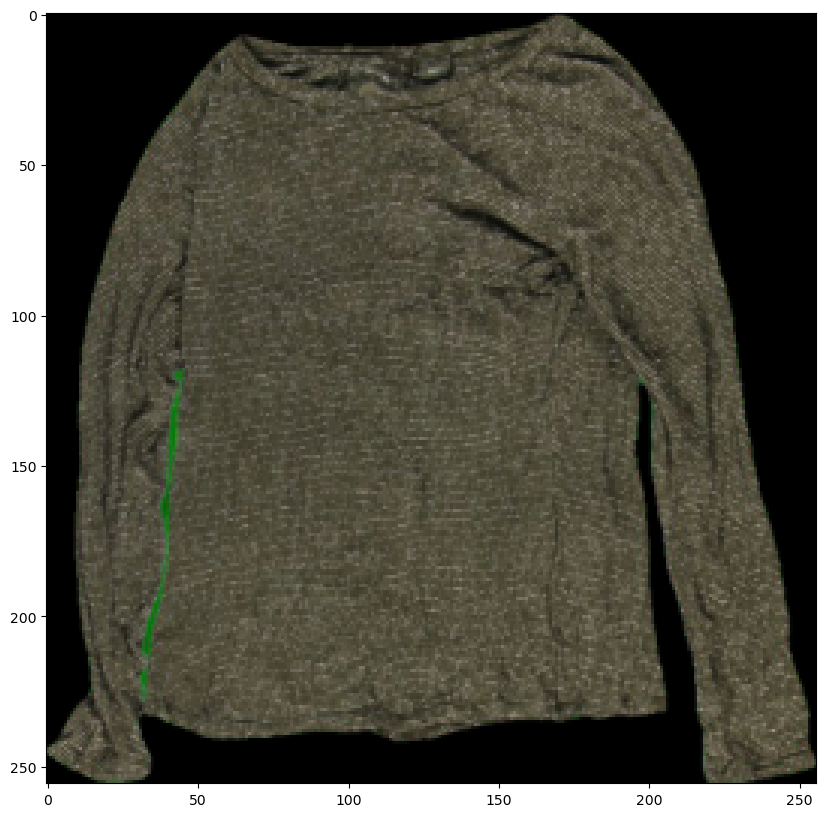

In [22]:
image = denormalize_image(images[0])

# De-normalize the image

sift_2 = cv2.SIFT_create()

step_size = 10
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, image.shape[0], step_size) 
                                    for x in range(0, image.shape[1], step_size)]

img=cv2.drawKeypoints(image, kp, None)
    
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.show()



kp, dense_feat = sift.compute(image, kp)

In [48]:
sift_2 = cv2.SIFT_create()

step_size = 10
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, 256, step_size) 
                                    for x in range(0, 256, step_size)]

def extact_sift_features_dense(image_array):
    
    image = denormalize_image(image_array)

    _, descriptors = sift_2.compute(image, kp)
    return descriptors

descriptors_list_dense = []
for image in tqdm(images):
    descriptors = extact_sift_features_dense(image)
    
    if descriptors is not None:
        descriptors_list_dense.append(descriptors)
    else:
        descriptors_list_dense.append(np.zeros((1, 128)))

100%|██████████| 5080/5080 [00:52<00:00, 97.46it/s] 


In [ ]:
for idx in range(10,20):
    # Load the image from the path
    image = denormalize_image(images[idx])

    
    # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Draw keypoints on the grayscale image
    # output_image = cv2.drawKeypoints(
    #     image, keypoints_list[idx], None, (255, 0, 0),
    #     flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    # )
    output_image = cv2.drawKeypoints(
        image, kp, None, (255, 0, 0),
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    # Display the image with keypoints using Matplotlib
    plt.imshow(output_image, cmap='gray')
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

In [27]:
descriptors_list_dense.shape

AttributeError: 'list' object has no attribute 'shape'

In [50]:
# Stack all descriptors together
all_descriptors = np.vstack(descriptors_list_dense)
print(all_descriptors.shape)
# Use K-means to create a visual vocabulary
k = 200  # Number of visual words
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)

# Save the cluster centers as the visual vocabulary
visual_words = kmeans.cluster_centers_

(3434080, 128)


In [51]:
# Save descriptors_list_dense to a file
with open('descriptors_list_dense.pkl', 'wb') as file:
    pickle.dump(descriptors_list_dense, file)
np.save('visual_words.npy', visual_words)
# Save the KMeans model
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

In [52]:
visual_words = np.load('visual_words.npy')
# Load descriptors_list_dense from the file
with open('descriptors_list_dense.pkl', 'rb') as file:
    descriptors_list_dense = pickle.load(file)
    # Load the KMeans model
with open('kmeans_model.pkl', 'rb') as file:
    kmeans = pickle.load(file)


In [53]:
print(visual_words.shape)

(200, 128)


In [54]:
# Function to create a histogram of visual words for an image
def create_histogram(descriptors, visual_words):
    histogram = np.zeros(len(visual_words))
    if descriptors is not None:
        words = kmeans.predict(descriptors)
        for word in words:
            histogram[word] += 1
    return histogram

# Create histograms for all images
histograms = []
for idx in tqdm(range(len(images))):
    descriptors = descriptors_list_dense[idx]
    histogram = create_histogram(descriptors, visual_words)
    histograms.append(histogram)

# Convert histograms to a NumPy array
X_train_bovw = np.array(histograms)

histograms_test = []
for idx in tqdm(range(len(images_test))):
    descriptors = extact_sift_features_dense(images_test[idx])
    histogram = create_histogram(descriptors, visual_words)
    histograms_test.append(histogram)

# Convert histograms to a NumPy array
X_test_bovw = np.array(histograms_test)

100%|██████████| 497/497 [00:05<00:00, 83.81it/s]


### Bag of Visual Words CREATED

In [55]:
print(f"Shape of BoVW histograms: {X_train_bovw.shape}")
print(f"Shape of item_sales: {item_sales.shape}")
print(f"Shape of categories: {categories.shape}")
print(f"Shape of colors: {colors.shape}")
print(f"Shape of fabrics: {fabrics.shape}")
print(f"Shape of temporal_features: {temporal_features.shape}")
print(f"Shape of gtrends: {gtrends.shape}")

print(f"Shape test of BoVW histograms: {X_test_bovw.shape}")
print(f"Shape test of item_sales: {item_sales_test.shape}")
print(f"Shape test of categories: {categories_test.shape}")
print(f"Shape test of colors: {colors_test.shape}")
print(f"Shape test of fabrics: {fabrics_test.shape}")
print(f"Shape test of temporal_features: {temporal_features_test.shape}")
print(f"Shape test of gtrends: {gtrends_test.shape}")

Shape of BoVW histograms: (5080, 200)
Shape of item_sales: (5080, 12)
Shape of categories: (5080,)
Shape of colors: (5080,)
Shape of fabrics: (5080,)
Shape of temporal_features: (5080, 4)
Shape of gtrends: (5080, 3, 52)
Shape test of BoVW histograms: (497, 200)
Shape test of item_sales: (497, 12)
Shape test of categories: (497,)
Shape test of colors: (497,)
Shape test of fabrics: (497,)
Shape test of temporal_features: (497, 4)
Shape test of gtrends: (497, 3, 52)


In [15]:
gtrends_flattened = gtrends.reshape(gtrends.shape[0], -1)
gtrends_flattened_test = gtrends_test.reshape(gtrends_test.shape[0], -1)
# Possible to compute statistical figures

In [49]:
gtrends_flattened.shape

(5080, 156)

In [131]:
X_train = np.hstack((
    # X_train_bovw,           
    # temporal_features,
    temporal_features_engineered,        
    # gtrends_flattened,
    gtrends_with_rolling_reduced,
    categories.reshape(-1, 1),
    colors.reshape(-1, 1),
    fabrics.reshape(-1, 1)
))

X_test = np.hstack((
    # X_test_bovw,
    # temporal_features_test,
    test_temporal_features_engineered,
    # gtrends_flattened_test,
    gtrends_test_with_rolling_reduced,
    categories_test.reshape(-1, 1),
    colors_test.reshape(-1, 1),
    fabrics_test.reshape(-1, 1)
))

# Combine train and test data for consistent scaling
X_combined = np.vstack((X_train, X_test))

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the combined data and transform
X_combined_scaled = scaler.fit_transform(X_combined)

# Split back into train and test sets
X_train_scaled = X_combined_scaled[:X_train.shape[0]]
X_test_scaled = X_combined_scaled[X_train.shape[0]:]

# y_train = total_sales
# y_test = total_sales_test

y_train = item_sales[:, 5]
y_test = item_sales_test[:, 5]

In [100]:
X_train.shape

(5080, 221)

### UMAP

In [132]:
# Initialize UMAP
umap_model = umap.UMAP(
    n_neighbors=15,    # Balances local and global structure
    min_dist=0.1,      # Controls the tightness of the embedding
    metric='euclidean',# Distance metric
    random_state=42    # For reproducibility
)

# Fit UMAP on the training data and transform
embedding_train = umap_model.fit_transform(X_train_scaled)

# Transform the test data using the same UMAP model
embedding_test = umap_model.transform(X_test_scaled)


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


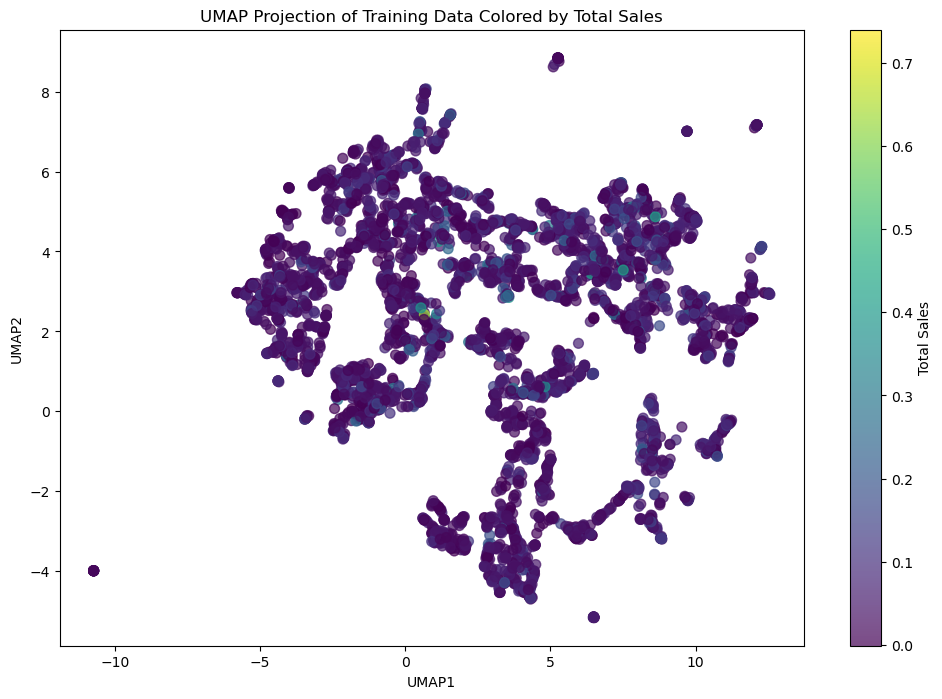

In [133]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embedding_train[:, 0],
    embedding_train[:, 1],
    c=y_train,
    cmap='viridis',
    s=50,
    alpha=0.7
)
plt.colorbar(scatter, label='Total Sales')
plt.title('UMAP Projection of Training Data Colored by Total Sales')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


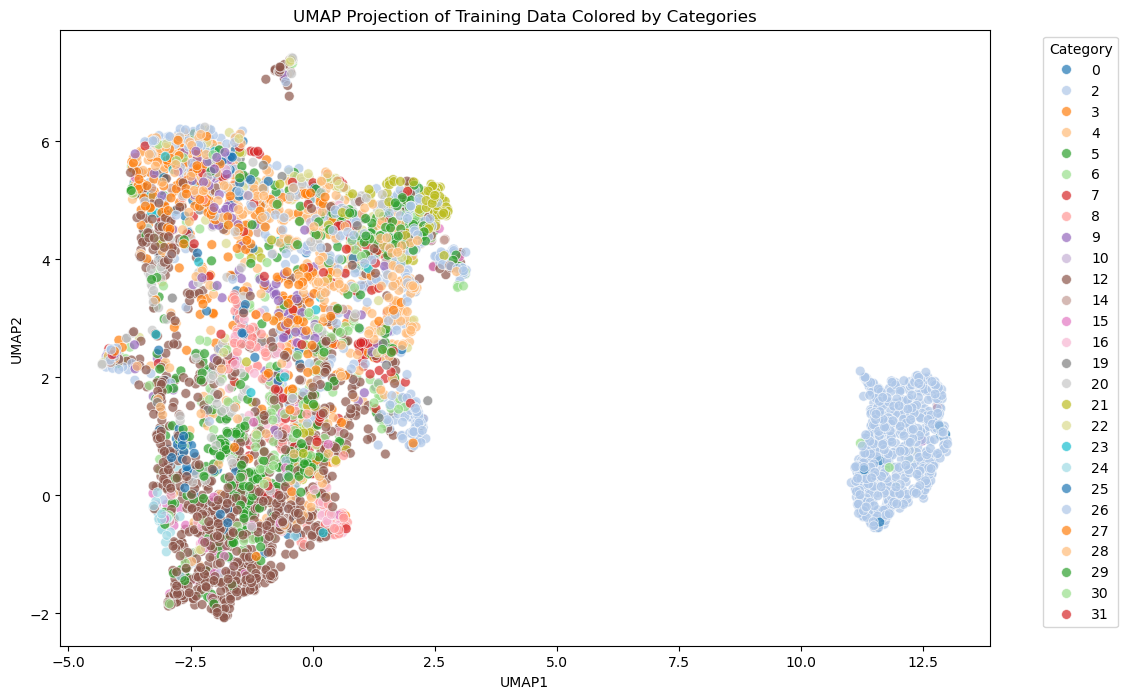

In [126]:
# If categories are integers or strings
categories_train = categories.flatten()

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=embedding_train[:, 0],
    y=embedding_train[:, 1],
    hue=categories_train,
    palette='tab20',
    s=50,
    alpha=0.7
)
plt.title('UMAP Projection of Training Data Colored by Categories')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [122]:
cat_dict

{'capris': 0,
 'cloak': 1,
 'culottes': 2,
 'doll dress': 3,
 'drop sleeve': 4,
 'gitana skirt': 5,
 'kimono dress': 6,
 'long cardigan': 7,
 'long coat': 8,
 'long dress': 9,
 'long duster': 10,
 'long skirt': 11,
 'long sleeve': 12,
 'longuette skirt': 13,
 'maxi': 14,
 'medium cardigan': 15,
 'medium coat': 16,
 'medium duster': 17,
 'midi skirt': 18,
 'miniskirt': 19,
 'patterned': 20,
 'printed': 21,
 'sheath dress': 22,
 'shirt dress': 23,
 'short cardigan': 24,
 'short coat': 25,
 'short sleeves': 26,
 'shorts': 27,
 'sleeveless': 28,
 'solid colours': 29,
 'tracksuit': 30,
 'trapeze dress': 31}

In [119]:
# Choose the number of dimensions for UMAP embeddings (e.g., 10)
umap_reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=10,
    metric='euclidean',
    random_state=42
)

# Fit and transform the training data
X_train_umap = umap_reducer.fit_transform(X_train_scaled)

# Transform the test data
X_test_umap = umap_reducer.transform(X_test_scaled)


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
print("Training the Linear Regression model on UMAP-reduced features...")
model.fit(X_train_umap, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_umap)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

Training the Linear Regression model on UMAP-reduced features...
Mean Squared Error: 0.2020697146654129
Root Mean Squared Error: 0.44952166080474854
R^2 Score: 0.006391584873199463


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


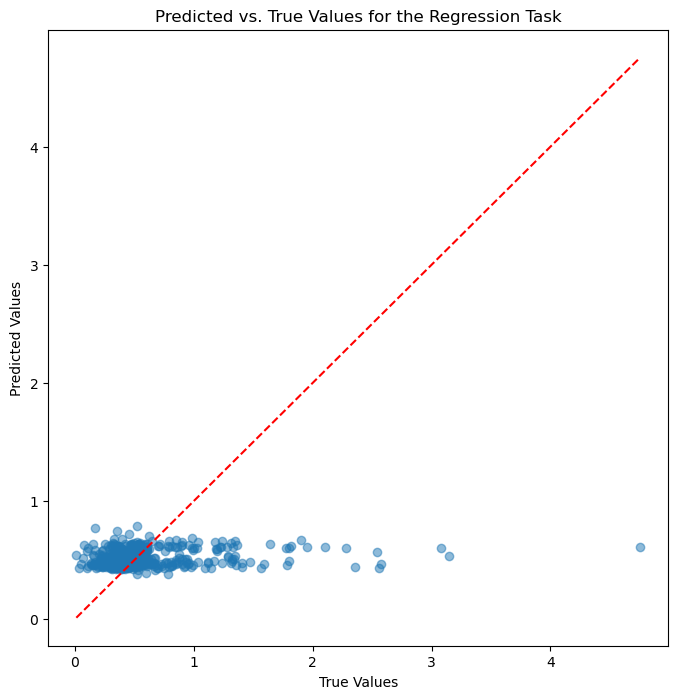

In [121]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')
plt.show()

### Models

In [93]:
# Initialize the XGBoost regressor
# model = XGBRegressor(
#     n_jobs=-1                # Use all CPU cores
# )
# model = XGBRegressor(
#     n_estimators=2000,       # Increase the number of trees
#     learning_rate=0.05,      # Lower learning rate for finer optimization
#     max_depth=10,            # Deeper trees for capturing more complexity
#     min_child_weight=5,      # Minimum sum of instance weight needed in a child
#     gamma=0.1,               # Minimum loss reduction required to make a further partition
#     subsample=0.8,           # Subsample ratio of the training instances
#     colsample_bytree=0.8,    # Subsample ratio of columns when constructing each tree
#     reg_alpha=0.1,           # L1 regularization term on weights (to reduce overfitting)
#     reg_lambda=0.5,          # L2 regularization term on weights
#     scale_pos_weight=1,      # Balances the positive and negative weights
#     max_delta_step=1,        # Maximum delta step we allow each tree's weight estimation to be
#     random_state=42,         # For reproducibility
#     n_jobs=-1                # Use all CPU cores
# )
model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4),  # Base estimator with limited depth to avoid overfitting
    n_estimators=100,                                   # Number of boosting rounds
    learning_rate=0.1,                                  # Learning rate to control the contribution of each estimator
    random_state=42                                     # For reproducibility
)
# Train the model
print("Training the regression model...")
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

Training the regression model...


In [94]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

Mean Squared Error on Test Set: 0.1966016889607849
Mean Absolute Error on Test Set: 0.28358907059857985


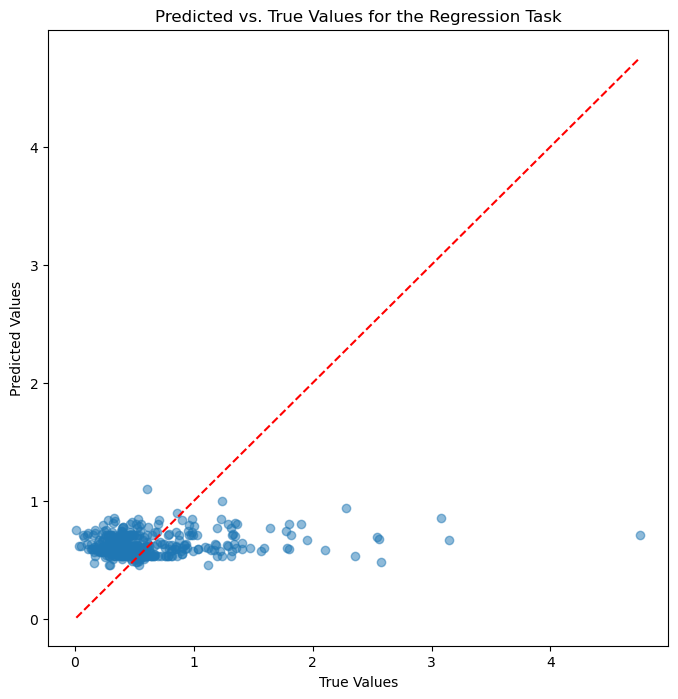

In [95]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')
plt.show()

In [20]:

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0,
    n_jobs=-1
)

# Perform grid search
print("Performing grid search...")
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

Performing grid search...
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best Score: 0.0003367047989740968


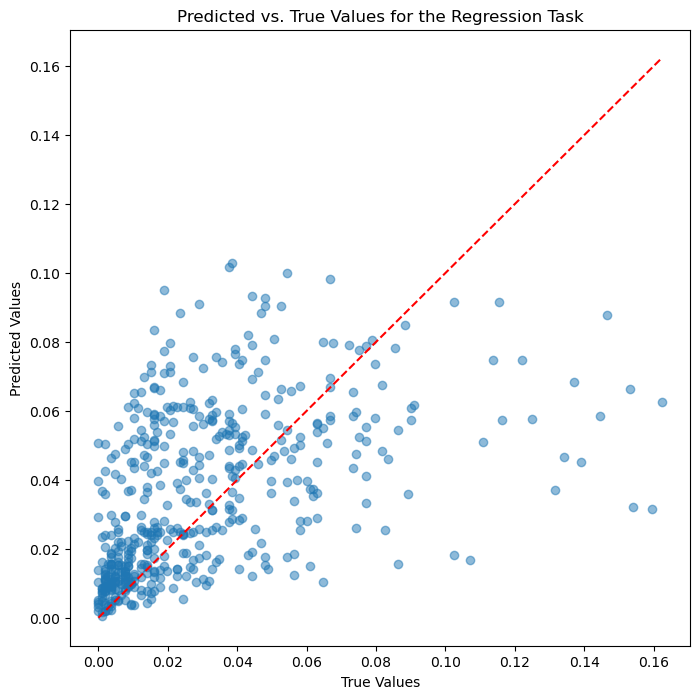

Mean Squared Error on Test Set: 0.0007980830268934369
Mean Absolute Error on Test Set: 0.020053241401910782


In [21]:
# Get the best model from the Grid Search
best_model = grid_search.best_estimator_

# Make predictions using the best model
y_pred_bm = best_model.predict(X_test)

# Plot the Predicted vs. True Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_bm, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')  # Line y = x for reference
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_bm)
mae = mean_absolute_error(y_test, y_pred_bm)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

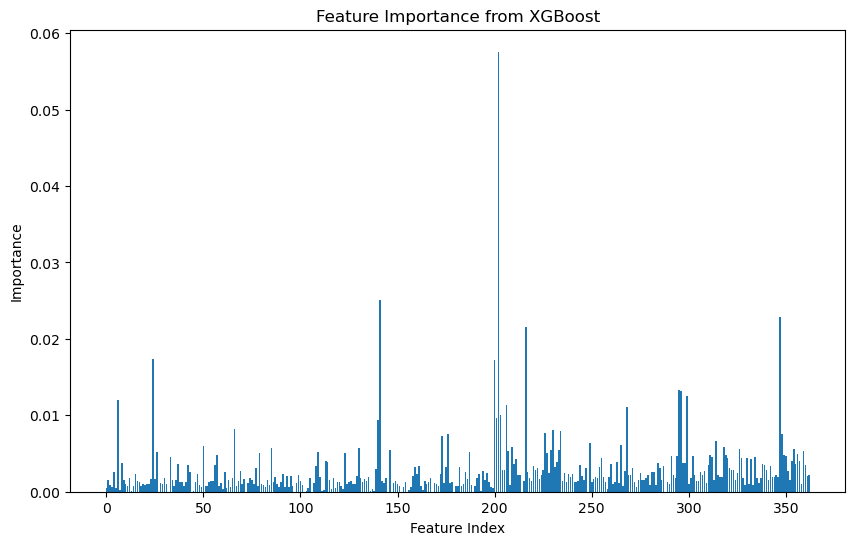

In [22]:
importance = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance from XGBoost")
plt.show()

In [23]:
# Set a threshold for feature importance
threshold = 0.01  # Adjust based on how many features you want to keep
important_features_indices = np.where(importance > threshold)[0]

# Select the important features
X_train_important = X_train[:, important_features_indices]
X_test_important = X_test[:, important_features_indices]
print(f"Shape of reduced features: {X_train_important.shape}")

Shape of reduced features: (5080, 13)


In [24]:
# Train the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X_train_important, y_train)

# Make predictions and evaluate
y_pred_imp = model.predict(X_test_important)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error with Important Features: {mse}")

Mean Squared Error with Important Features: 0.0008077869424596429


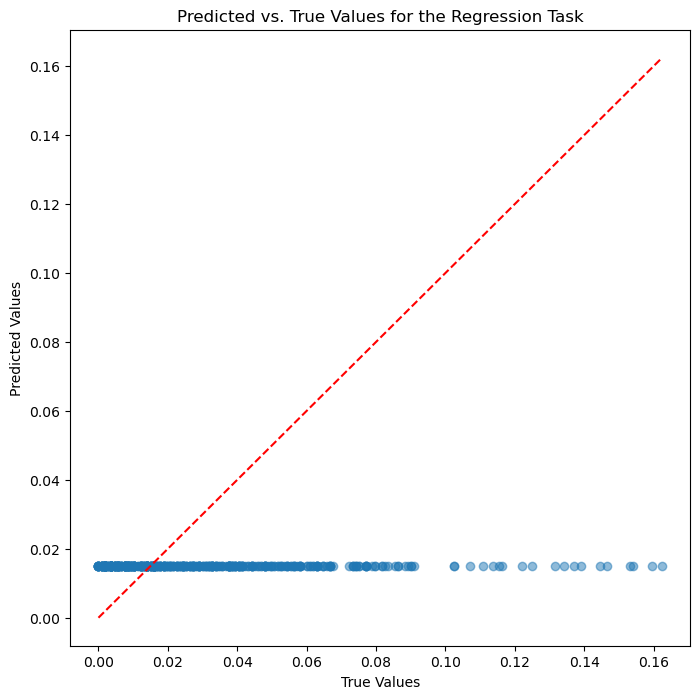

Mean Squared Error on Test Set: 0.00112123571047348
Mean Absolute Error on Test Set: 0.021581880405351896


In [25]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply Lasso regression
lasso = Lasso(alpha=0.015)  # Adjust alpha for the strength of regularization
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(scaler.transform(X_test))

# Get the coefficients
lasso_coefficients = lasso.coef_

# Plot the Predicted vs. True Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')  # Line y = x for reference
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

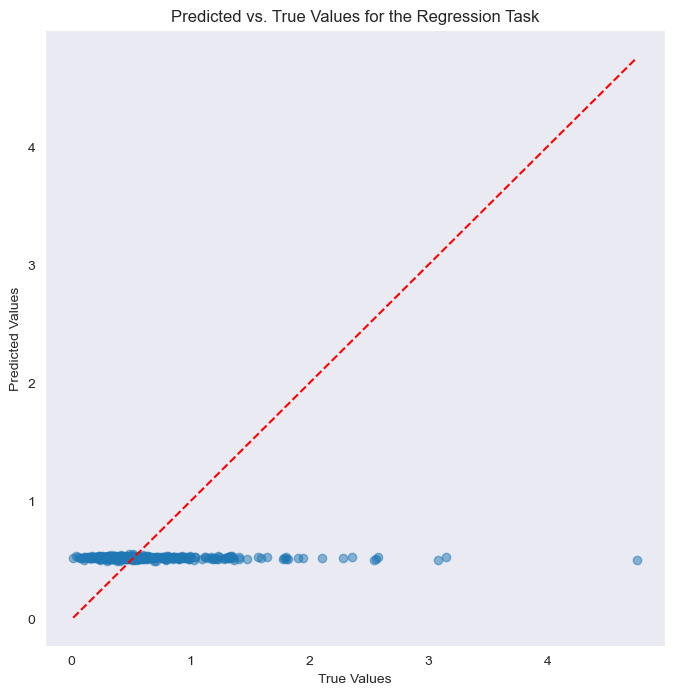

Mean Squared Error on Test Set: 0.2079427101892498
Mean Absolute Error on Test Set: 0.2530742177585954


In [114]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bovw)

# Apply Lasso regression
lasso = Lasso(alpha=0.01)  # Adjust alpha for the strength of regularization
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(scaler.transform(X_test_bovw))

# Get the coefficients
lasso_coefficients = lasso.coef_

# Plot the Predicted vs. True Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')  # Line y = x for reference
plt.show()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_lasso)
mae = mean_absolute_error(y_test, y_pred_lasso)

print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

In [26]:
# Transform the target variable using log1p
y_train_transformed = np.log1p(y_train)
y_test_transformed = np.log1p(y_test)

# y_train_transformed = np.sqrt(y_train)
# y_test_transformed = np.sqrt(y_test)


# Train the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train_transformed)

# Make predictions and transform them back to the original scale
y_pred_transformed = model.predict(X_test)

y_pred = np.expm1(y_pred_transformed)  # Inverse of log1p

# Evaluate the model
mse = mean_squared_error(y_test_transformed, y_pred_transformed)  # Use the transformed target
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.0006782413693144917


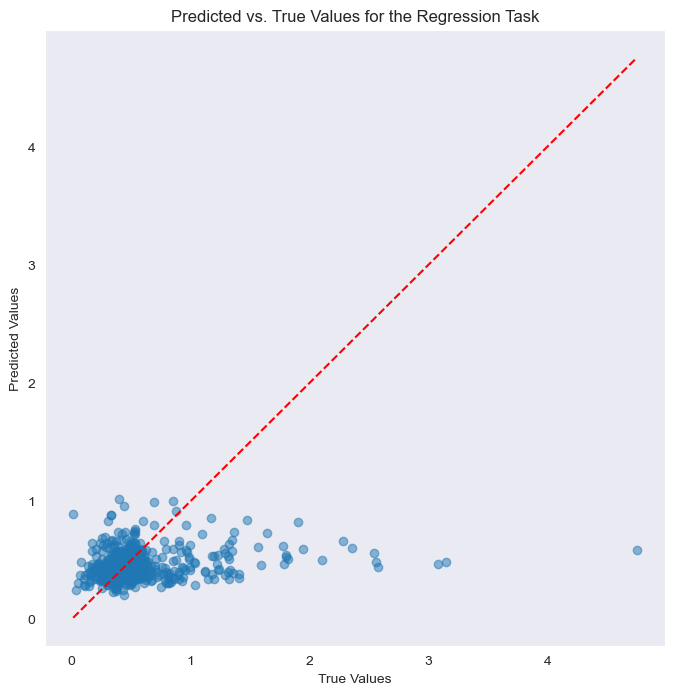

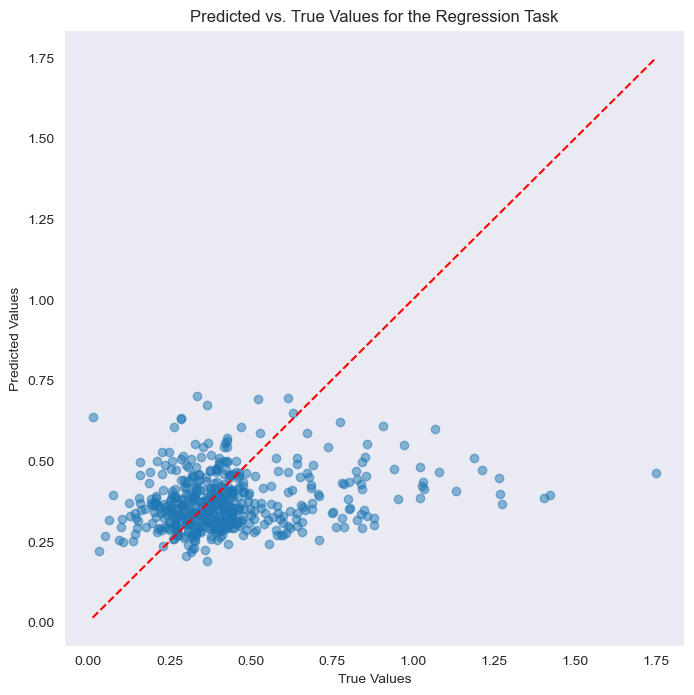

Mean Squared Error on Test Set: 0.21266327798366547
Mean Absolute Error on Test Set: 0.25937238335609436


In [121]:
# Plot the Predicted vs. True Values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)], 'r--')  # Line y = x for reference
plt.show()

plt.figure(figsize=(8, 8))
plt.scatter(y_test_transformed, y_pred_transformed, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. True Values for the Regression Task")
plt.plot([min(y_test_transformed), max(y_test_transformed)],
         [min(y_test_transformed), max(y_test_transformed)], 'r--')  # Line y = x for reference
plt.show()

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f"Mean Squared Error on Test Set: {mse}")
print(f"Mean Absolute Error on Test Set: {mae}")

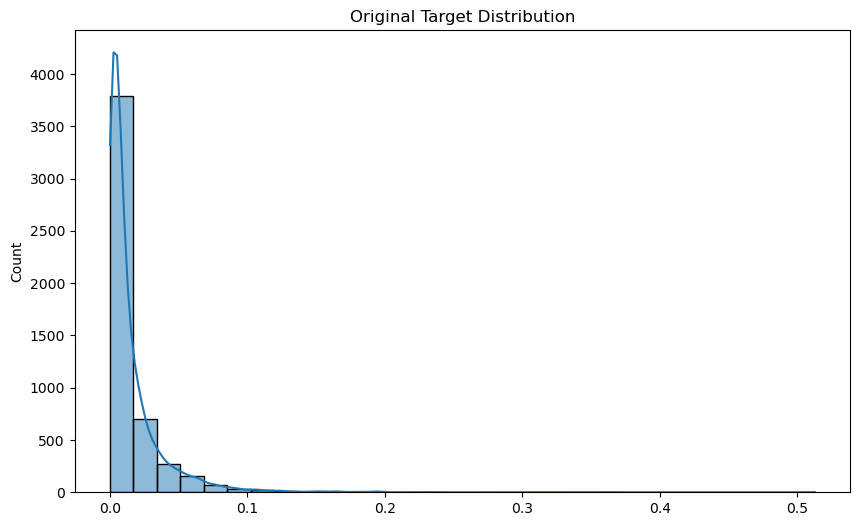

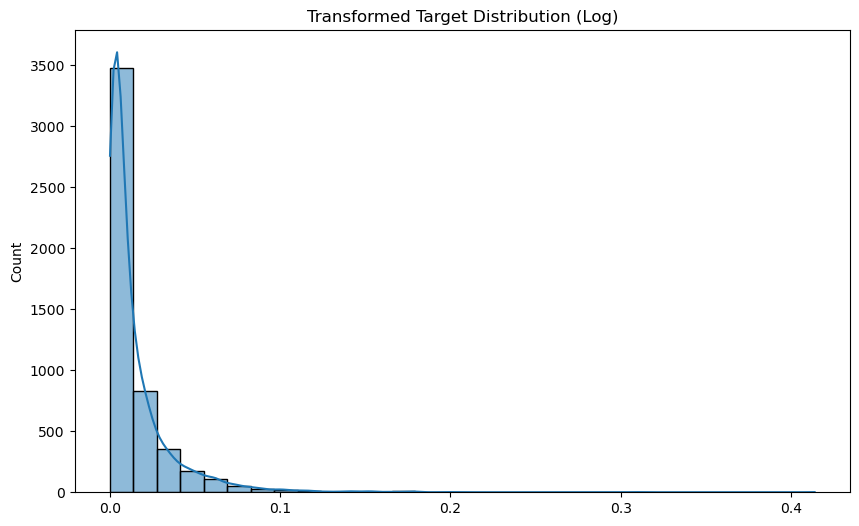

In [27]:
# Original target distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=30, kde=True)
plt.title('Original Target Distribution')
plt.show()

# Transformed target distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_train_transformed, bins=30, kde=True)
plt.title('Transformed Target Distribution (Log)')
plt.show()


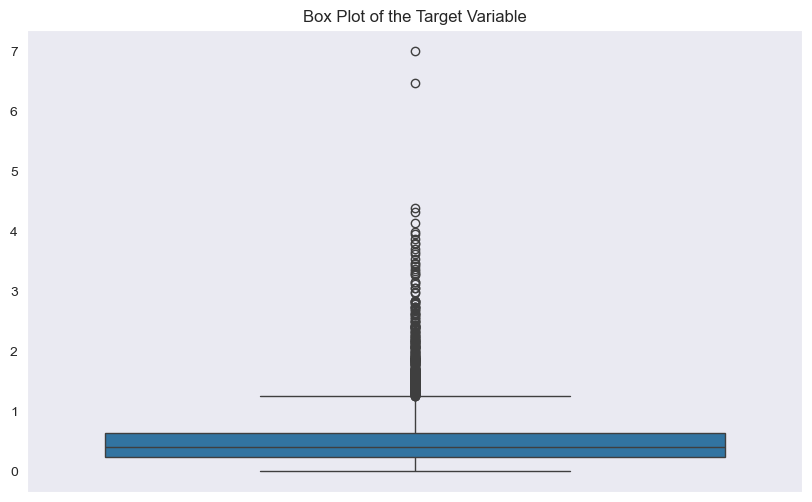

In [123]:
# Check for outliers in the target variable
plt.figure(figsize=(10, 6))
sns.boxplot(sale)
plt.title('Box Plot of the Target Variable')
plt.show()
